## Port Elizabeth Crime Forecasting
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Kwazakele</li>
</ul>

### Importing libraries

In [1]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px

In [2]:
#sns.set_style("darkgrid")

### Data preprocessing

In [3]:
df = pd.read_csv('crimedata.csv', thousands=',') #Thousands are seperated by commas in the CSV.

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
Crime                  0
Crimes                 0
Police Station         0
Province               0
Crime Category         0
Latitude               0
Longitude              0
Latitude, Longitude    0
Year                   0
dtype: int64


Index(['Crime', 'Crimes', 'Police Station', 'Province', 'Crime Category',
       'Latitude', 'Longitude', 'Latitude, Longitude', 'Year'],
      dtype='object')


#### Let's convert Crime Category, Police Station, and Crime to pd.Categorical

In [4]:
df['Crime'] = pd.Categorical(df['Crime'])
df['Police Station'] = pd.Categorical(df['Police Station'])
df['Crime Category'] = pd.Categorical(df['Crime Category'])

### What are the datatypes used?

In [5]:
df.dtypes

Crime                  category
Crimes                    int64
Police Station         category
Province                 object
Crime Category         category
Latitude                float64
Longitude               float64
Latitude, Longitude      object
Year                      int64
dtype: object

#### What does the csv file look like?

In [6]:
df

,Crime,Crimes,Police Station,Province,Crime Category,Latitude,Longitude,"Latitude, Longitude",Year
0,Murder,5,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
1,Attempted murder,3,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
2,Assault with the intent to inflict grievous bo...,67,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
3,Common assault,31,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
4,Common robbery,2,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
...,...,...,...,...,...,...,...,...,...
346465,Shoplifting,88,Walmer,Eastern Cape,Other Serious Crimes,-33.978868,25.585376,"-33.9788678, 25.5853756",2022
346466,Illegal possession of firearms and ammunition,10,Walmer,Eastern Cape,Crime detected as a result of Police Action,-33.978868,25.585376,"-33.9788678, 25.5853756",2022
346467,Drug-related crime,106,Walmer,Eastern Cape,Crime detected as a result of Police Action,-33.978868,25.585376,"-33.9788678, 25.5853756",2022
346468,Driving under the influence of alcohol or drugs,34,Walmer,Eastern Cape,Crime detected as a result of Police Action,-33.978868,25.585376,"-33.9788678, 25.5853756",2022


#### Limit provinces to only Eastern Cape. After some careful analysis, I found out that there is some incorrect data that has been input. The Police Station 'Doringkloof' does not exist within the Eastern Cape. Doringkloof is a suburb in Gauteng. Therefore, we remove this.

In [7]:
df = df[df['Province'] == 'Eastern Cape']
df = df[df['Police Station'] != 'Doringkloof']

#### The CSV file we use lists Kwazekele, a police station in Port Elizabeth, as having coordinates near East London. Let's change this

In [8]:
df.loc[df['Police Station'] == 'Kwazakele', 'Latitude'] = -33.87626
df.loc[df['Police Station'] == 'Kwazakele', 'Longitude'] = 25.58308

#### Limit to police stations in Port Elizabeth only

In [9]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Bethelsdorp", "Motherwell"
            , "Kwazakele", "Ikamvelihle"]
df = df[df['Police Station'].isin(stations)]
df.drop(['Latitude, Longitude', 'Province'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv('PEcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within PE only
#Stations right outside of PE: Kamesh , Despatch, Uitenhage, Kwanobuhle

#### Let's load the SHP file of South Africa

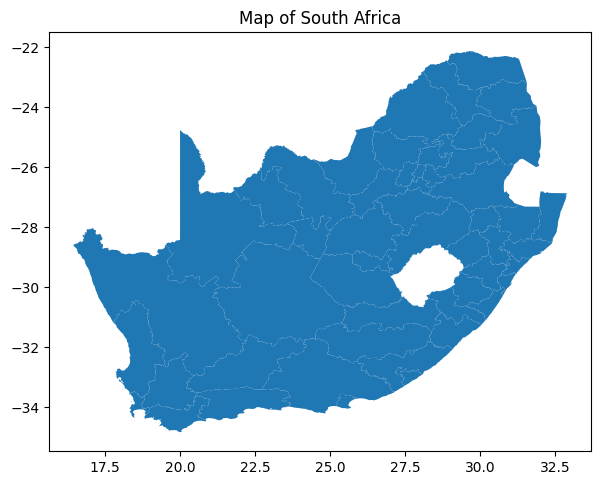

In [10]:
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_2.shp")
fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax = ax)
plt.title('Map of South Africa')
plt.show()

### Let's plot the police stations within Port Elizabeth only.

##### But first, group by police station and sum the crimes.

In [11]:
sum_crimes = df.groupby(['Police Station'], observed=True)['Crimes'].sum()
sum_crimes = sum_crimes.reset_index()
sum_crimes['Latitude'] = df['Latitude'].unique()
sum_crimes['Longitude'] = df['Longitude'].unique()
sum_crimes['size'] = sum_crimes['Crimes'] / 60
    
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(sum_crimes, crs = {'init': 'epsg:4326'}, geometry=[Point(xy) for xy in zip(sum_crimes['Longitude'], sum_crimes['Latitude'])])

c:\Users\user-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


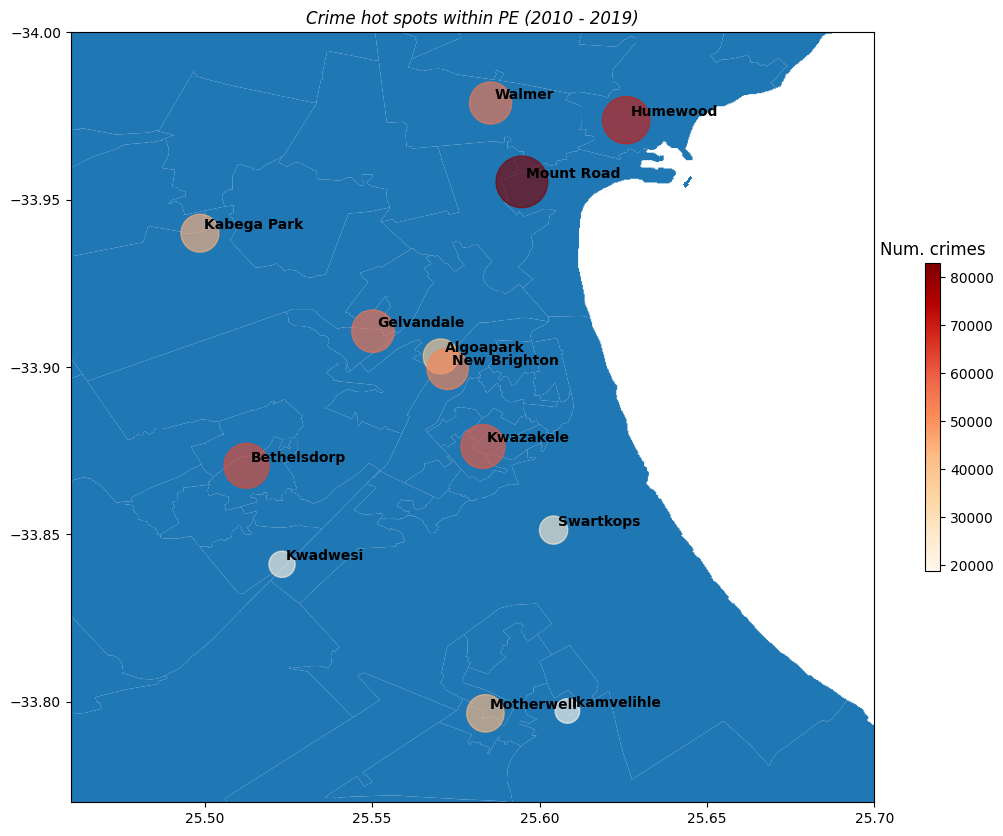

In [12]:
fig, ax = plt.subplots(figsize=(13,10))
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_4.shp")
map.plot(ax=ax, aspect=1) #Plot the map of South Africa
geo_df.plot(aspect=1, column='Crimes', ax=ax, markersize='size', cmap='OrRd', legend=True, alpha=0.65, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same SA map.
ax.set_ylim([-33.77, -34])
ax.set_xlim([25.46, 25.7])
plt.title('Crime hot spots within PE (2010 - 2019)', style='italic')
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", weight='bold')
ax.get_figure().get_axes()[1].set_title("Num. crimes")
plt.show()

### An interactive map of crime hotspots in PE

In [36]:
fig = px.scatter_mapbox(sum_crimes, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=10, height=600, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [14]:
geo_df

,Police Station,Crimes,Latitude,Longitude,size,geometry
0,Algoapark,38140,-33.903171,25.570496,635.666667,POINT (25.57050 -33.90317)
1,Bethelsdorp,63089,-33.870520,25.512471,1051.483333,POINT (25.51247 -33.87052)
2,Gelvandale,56207,-33.910708,25.550250,936.783333,POINT (25.55025 -33.91071)
3,Humewood,69647,-33.973749,25.625900,1160.783333,POINT (25.62590 -33.97375)
4,Ikamvelihle,18720,-33.797272,25.608320,312.000000,POINT (25.60832 -33.79727)
5,Kabega Park,44750,-33.939980,25.498567,745.833333,POINT (25.49857 -33.93998)
6,Kwadwesi,21329,-33.841086,25.523082,355.483333,POINT (25.52308 -33.84109)
7,Kwazakele,60383,-33.876260,25.583080,1006.383333,POINT (25.58308 -33.87626)
8,Motherwell,43477,-33.796568,25.583835,724.616667,POINT (25.58384 -33.79657)
9,Mount Road,82896,-33.955318,25.594730,1381.600000,POINT (25.59473 -33.95532)


### EDA

In [15]:
df[(df['Police Station'] == 'Algoapark') & (df['Year'] == 2019)]

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
3510,Murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3511,Attempted murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3512,Assault with the intent to inflict grievous bo...,137,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3513,Common assault,223,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3514,Common robbery,81,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3515,Robbery with aggravating circumstances,262,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3516,Rape,52,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3517,Sexual Assault,12,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3518,Attempted Sexual Offences,0,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3519,Contact Sexual Offences,7,Algoapark,Sexual Offences,-33.903171,25.570496,2019


In [16]:
df_grouped = df.groupby(['Police Station'], observed=True)['Crimes'].sum()
df_grouped_year = df.groupby(['Police Station', 'Year'], observed=True)['Crimes'].sum()
df_grouped_y = df.groupby(['Year'], observed=True)['Crimes'].sum()

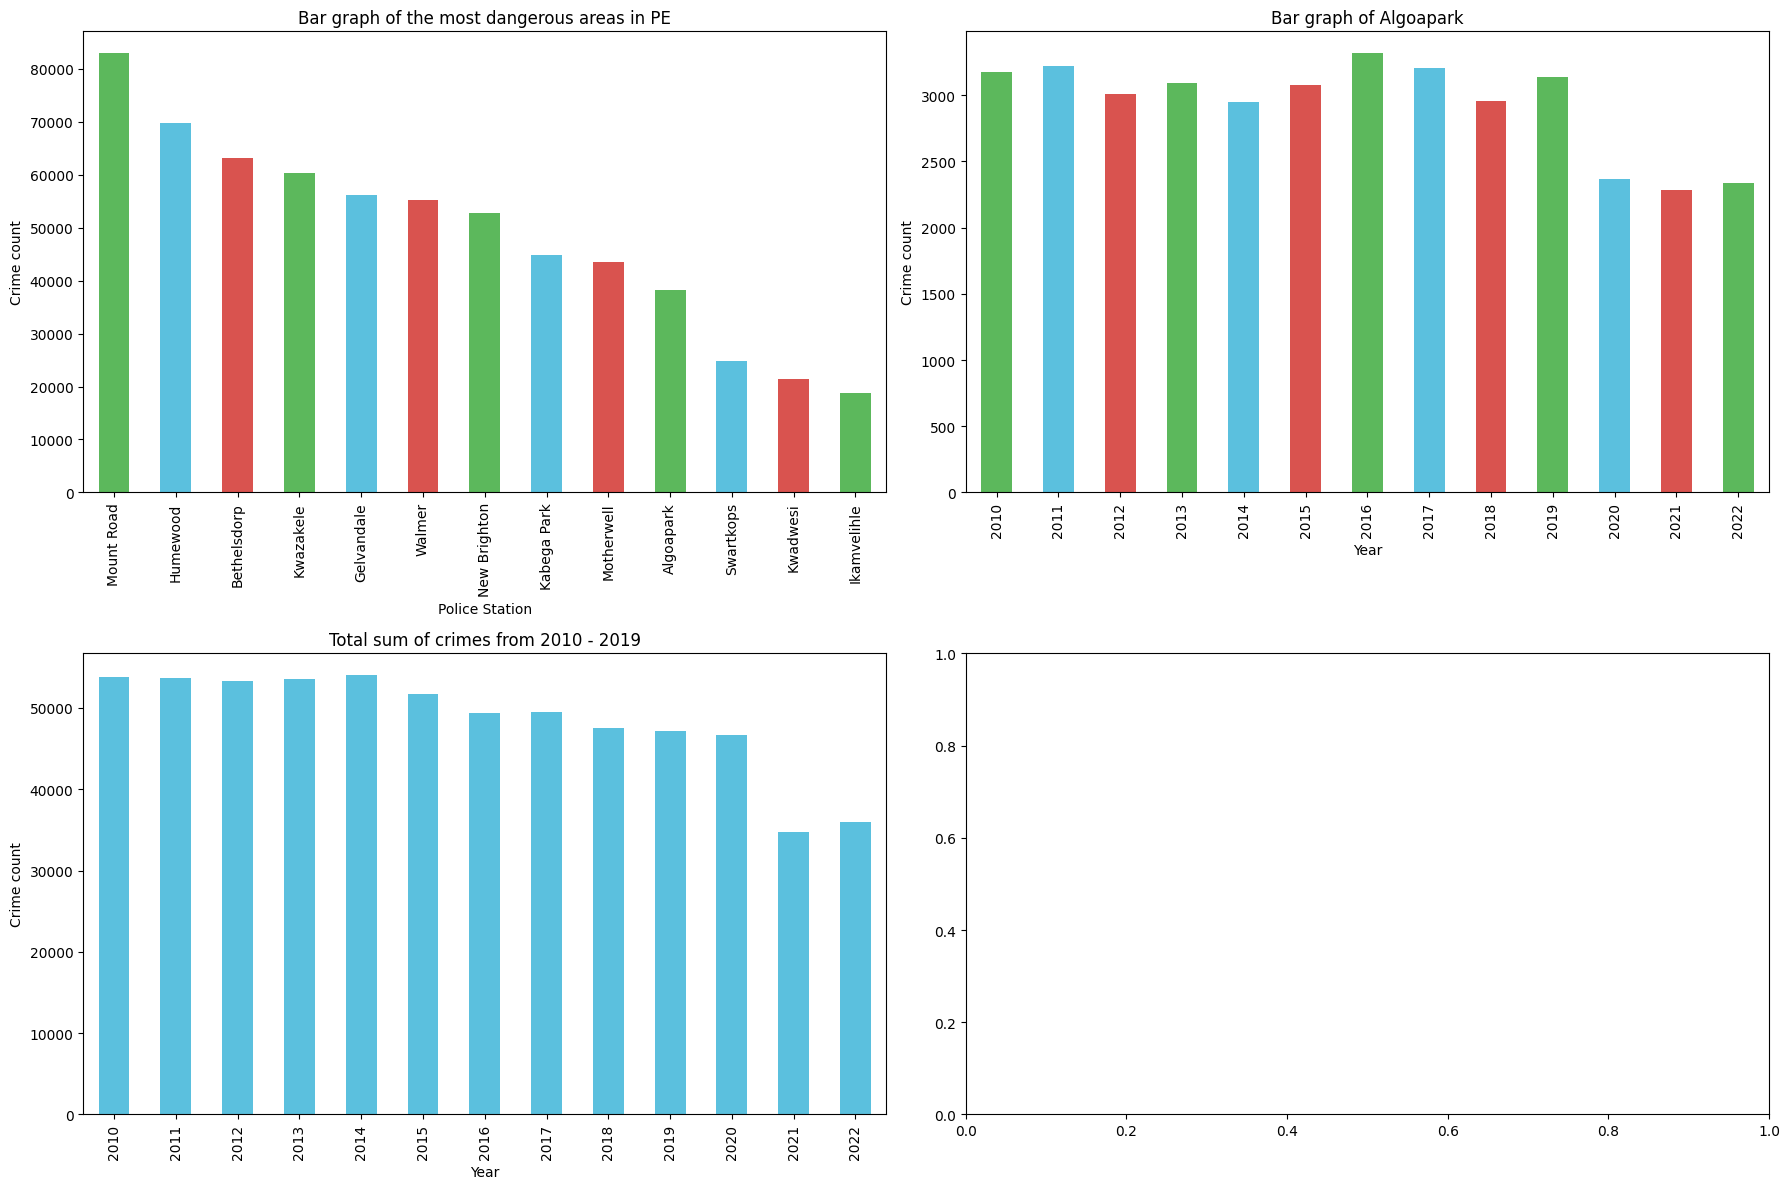

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

df_grouped.sort_values(ascending=False).plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,0])
df_grouped_year['Algoapark'].plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,1])
df_grouped_y.plot.bar(color=['#5bc0de'], ax=axs[1,0])
#sns.barplot(df_grouped, ax=axs[0,0], x='Police Station', y='Crimes')

axs[0,0].set_title('Bar graph of the most dangerous areas in PE')
axs[0,0].set_xlabel('Police Station')
axs[0,0].set_ylabel('Crime count')

axs[0,1].set_title('Bar graph of Algoapark')
axs[0,1].set_xlabel('Year')
axs[0,1].set_ylabel('Crime count')

axs[1,0].set_title('Total sum of crimes from 2010 - 2019')
axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Crime count')

plt.tight_layout()

In [18]:
df_grouped = df_grouped.reset_index()
df_grouped

,Police Station,Crimes
0,Algoapark,38140
1,Bethelsdorp,63089
2,Gelvandale,56207
3,Humewood,69647
4,Ikamvelihle,18720
5,Kabega Park,44750
6,Kwadwesi,21329
7,Kwazakele,60383
8,Motherwell,43477
9,Mount Road,82896


In [19]:
fig = px.pie(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
fig.update_layout(margin=dict(t=70, b=20, l=0, r=0))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [20]:
# fig = px.treemap(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
# fig.show()

df.groupby(['Crime Category'], observed=True)['Crimes'].sum().sort_values(ascending=False)

Crime Category
Contact Crimes                                 178913
Property-Related Crimes                        157408
Other Serious Crimes                           135058
Crime detected as a result of Police Action     74759
Contact-Related Crimes                          46726
Aggravated Robbery                              21172
Sexual Offences                                 17224
Name: Crimes, dtype: int64

#### There are 30 unique classes of crimes with 7 unique crime categories

In [21]:
df[(df['Police Station'] == 'Algoapark') & (df['Year'] == 2019)]

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
3510,Murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3511,Attempted murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3512,Assault with the intent to inflict grievous bo...,137,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3513,Common assault,223,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3514,Common robbery,81,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3515,Robbery with aggravating circumstances,262,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3516,Rape,52,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3517,Sexual Assault,12,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3518,Attempted Sexual Offences,0,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3519,Contact Sexual Offences,7,Algoapark,Sexual Offences,-33.903171,25.570496,2019


### Now, for the actual Machine Learning

#### Import

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

#### Data aquisition and categorical encoding

In [23]:
X = df.drop(['Crime Category', 'Crime', 'Latitude', 'Longitude'], axis=1)
y = df.iloc[:, 0]

# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
# X = ct.fit_transform(X)
X

,Crimes,Police Station,Year
0,20,Algoapark,2010
1,14,Algoapark,2010
2,158,Algoapark,2010
3,369,Algoapark,2010
4,54,Algoapark,2010
...,...,...,...
5065,88,Walmer,2022
5066,10,Walmer,2022
5067,106,Walmer,2022
5068,34,Walmer,2022


#### Sampling/split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Algorithm training

In [25]:
clfRandom = RandomForestClassifier()
clfAda = AdaBoostClassifier()
clfCat = CatBoostClassifier(verbose=0, n_estimators=100, cat_features=['Police Station'])

clfCat.fit(X_train, y_train)
#clfRandom.fit(X_train, y_train)
#clfAda.fit(X_train, y_train)

#### Cross-validation

In [26]:
cv = KFold(n_splits=5)

cv_score_Cat = cross_val_score(clfCat, X_train, y_train, cv=cv, scoring='accuracy')
# cv_score_Random = cross_val_score(clfRandom, X_train, y_train, cv=cv, scoring='f1_weighted')
# cv_score_Ada = cross_val_score(clfAda, X_train, y_train, cv=cv, scoring='f1_weighted')
# print('Random forests: ' + str(round(cv_score_Random.mean()*100, 2)) + ' ' + str(round(cv_score_Random.std()*100,2)) + " test:", str(round(accuracy_score(y_test, clfRandom.predict(X_test))*100,2)))
# print('AdaBoost: ' + str(round(cv_score_Ada.mean()*100, 2)) + ' ' + str(round(cv_score_Ada.std()*100,2)) + " test:", str(round(accuracy_score(y_test, clfAda.predict(X_test))*100,2)))

In [27]:
print('Catboost: ' + str(round(cv_score_Cat.mean()*100, 2)) + '% ' + str(round(cv_score_Cat.std()*100,2)) + " std, test:", str(round(accuracy_score(y_test, clfCat.predict(X_test))*100,2)))

Catboost: 13.19% 0.58 std, test: 14.0


In [28]:
y_test

2021                      Robbery at residential premises
1840                                           Carjacking
3316                                                Arson
1893                                       Common assault
1988                            Attempted Sexual Offences
                              ...                        
1592    Assault with the intent to inflict grievous bo...
353                     All theft not mentioned elsewhere
2380                                           Carjacking
4651                                     Attempted murder
4588      Driving under the influence of alcohol or drugs
Name: Crime, Length: 1521, dtype: category
Categories (31, object): ['All theft not mentioned elsewhere', 'Arson', 'Assault with the intent to inflict grievous b..., 'Attempted Sexual Offences', ..., 'Theft of motor vehicle and motorcycle', 'Theft out of or from motor vehicle', 'Truck hijacking', 'Truck hijacking ']

### Thanks for reading!